In [1]:
pip install --upgrade umap-learn

In [2]:
pip install ucimlrepo

In [4]:
pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=150a6d00f60898e1fdf974d8d7615406d83f4c87792079b2bd6ca3e2ede00eaa
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [2]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import umap
from keras.optimizers import Adam
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler

In [3]:

# fetch dataset
#spambase = fetch_ucirepo(id=94)
spambase = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = spambase.data.features
y = spambase.data.targets

In [4]:
y = (y == "M").astype(int)

In [5]:
#drop the columns that are not frequency counts
#X = X.drop(X.columns[54:57], axis=1)

In [6]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#transform to one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [7]:
#X_train = X_train / X_train.max()
#X_test = X_test / X_test.max()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
original_dim = X_train.shape[1]
latent_dim = 16
intermediate_dim = 256

In [50]:
#input layer
inputs = Input(shape=(original_dim,))
labels = Input(shape=(2,))

#dense layer with relu activation
h = Dense(intermediate_dim, activation='relu')(inputs)

In [51]:
## encoder model ##

# parameters of latent distribution
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [52]:
# sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [53]:
# sample vector from latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [54]:
# classifier
classifier_h = Dense(intermediate_dim, activation='relu')(z)
classifier_output = Dense(2, activation='softmax')(classifier_h)

In [55]:
### Decoder model ###

# Dense layer with relu activation takes sampled latent space vector z and maps it to an intermediate space
decoder_h = Dense(intermediate_dim, activation='relu')

# Dense layer with sigmoid activation takes the intermediate space vector and maps it back to the original dimension
#decoder_mean = Dense(original_dim, activation='sigmoid')
decoder_mean = Dense(original_dim, activation='tanh')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [56]:
# VAE model
vae = Model([labels, inputs], [x_decoded_mean,classifier_output])

In [57]:
# Define the VAE loss

# Reconstruction loss
rec_loss = original_dim * binary_crossentropy(inputs, x_decoded_mean)
#rec_loss = K.mean(K.square(inputs - x_decoded_mean), axis=-1)
# KL divergence loss
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#classifier loss
class_loss = binary_crossentropy(labels, classifier_output)
# Total loss
vae_loss = K.mean(rec_loss + kl_loss + class_loss)



In [58]:
vae.add_loss(vae_loss)
optimizer = Adam(learning_rate=0.0001)
vae.compile(optimizer=optimizer)

In [59]:
# Train the VAE model
vae.fit([y_train, X_train], epochs=800, batch_size=64, validation_data=([y_test, X_test], None))

Epoch 1/800
8/8 [==============================] - 2s 40ms/step - loss: 9.5065 - val_loss: 5.3733
Epoch 2/800
8/8 [==============================] - 0s 9ms/step - loss: 6.7280 - val_loss: 3.9652
Epoch 3/800
8/8 [==============================] - 0s 10ms/step - loss: 12.1927 - val_loss: 5.0153
Epoch 4/800
8/8 [==============================] - 0s 10ms/step - loss: 12.2832 - val_loss: 1.8383
Epoch 5/800
8/8 [==============================] - 0s 11ms/step - loss: 7.4107 - val_loss: 0.0726
Epoch 6/800
8/8 [==============================] - 0s 8ms/step - loss: 4.7306 - val_loss: 0.0837
Epoch 7/800
8/8 [==============================] - 0s 9ms/step - loss: 1.6156 - val_loss: -2.8285
Epoch 8/800
8/8 [==============================] - 0s 11ms/step - loss: -7.0591 - val_loss: 1.6699
Epoch 9/800
8/8 [==============================] - 0s 14ms/step - loss: -3.0612 - val_loss: -6.7288
Epoch 10/800
8/8 [==============================] - 0s 15ms/step - loss: 6.8236 - val_loss: 1.6447
Epoch 11/800
8/8

In [60]:
# Build the encoder model
encoder = Model(inputs, [z_mean, z_log_var])
z_mean, z_log_var = encoder.predict(X_test, batch_size=64)

2/2 [==============================] - 0s 8ms/step


In [61]:
# locate data points in latent space
data_point = X_test[0]
data_point_encoding = [z_mean[0], z_log_var[0]]

In [62]:
# draw 5 samples from the latent distribution
epsilon = np.random.normal(size=(5, latent_dim))
z_sample = data_point_encoding[0] + np.exp(data_point_encoding[1] / 2) * epsilon


In [63]:
# build decoder model
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)


In [64]:
# decode samples
x_decoded = decoder.predict(z_sample)

1/1 [==============================] - 0s 57ms/step


In [65]:
# build classifier model
classifier = Model(inputs, classifier_output)
classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# evaluate classifier
score = classifier.evaluate(X_test, y_test, batch_size=64)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 8ms/step - loss: 0.1332 - accuracy: 0.9649
Test loss: 0.1331651210784912
Test accuracy: 0.9649122953414917


In [66]:
# visualize decoded samples and original data point
print("Original data point:")
print(np.array(data_point))
print("Decoded sample:")
print(x_decoded[0])

Original data point:
[-0.77089916 -2.00602473 -0.76451652 -0.71183971 -0.1583148  -0.68680034
 -0.66248612 -0.57475415 -0.53582061 -0.22760708 -0.93280815 -1.37244026
 -0.85278289 -0.6368401  -0.2999339  -0.56993036 -0.53250895 -0.83258923
 -0.8416237  -0.59337276 -0.72135781 -1.63595077 -0.70654903 -0.65337009
  0.96851866 -0.10446758 -0.30668651 -0.38805702  0.16254727  0.06095804]
Decoded sample:
[-0.60909164 -0.5245661  -0.705384   -0.68095624 -0.15560989 -0.5973499
 -0.9023529  -0.6368412  -0.51432097  0.02113484 -0.8448935  -0.69120574
 -0.8366039  -0.7333289  -0.26342794 -0.69899035 -0.6659772  -0.70562315
 -0.03403602 -0.4072827  -0.5297695  -0.61175483 -0.7191531  -0.801226
  0.09644831 -0.5571597  -0.53584635 -0.82142574 -0.42760408 -0.18545257]


In [67]:
visualization_data = np.vstack(list(np.array(X_test)[1:])+ [data_point] + list(x_decoded))

In [68]:
# Create labels for the visualization
labels = ["other data point in X_test"]*len(X_test[1:]) + ["Original data point"] + ["Generated"]*5
colors = ["darkslategray"]*len(X_test[1:]) + ["red"] + ["sienna"]*5

In [69]:
# Apply UMAP for visualization
umap_model = umap.UMAP(n_components=2)
visualized_data = umap_model.fit_transform(visualization_data)

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


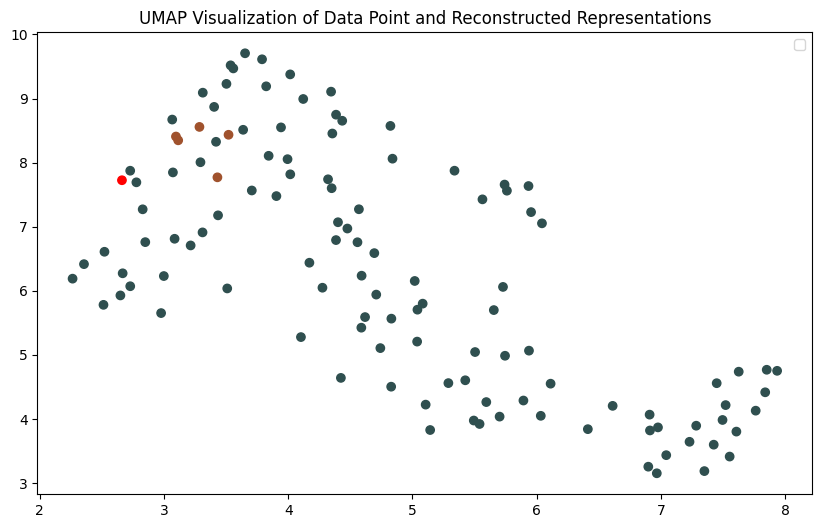

In [70]:
# Plot the visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(visualized_data[:, 0], visualized_data[:, 1], c=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.title('UMAP Visualization of Data Point and Reconstructed Representations')
plt.show()